In [157]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last' #all last

import pandas as pd
import numpy as np
import os, sys, random
sys.path.append('F:\my_documnet_F')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from importlib import reload
plt=reload(plt)
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import datetime
import seaborn as sns
from scipy import sparse
# import mglearn

import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statistics import mean

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

#Auto reloads notebook when changes are made
%reload_ext autoreload
%autoreload 2
import matplotlib.ticker as ticker

import imp
import Library.Rawdata_stack as rawstack
imp.reload(rawstack)

<module 'Library.Rawdata_stack' from 'F:\\my_documnet_F\\Library\\Rawdata_stack.py'>

In [158]:
path = './data/houseprices/'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_submission = pd.read_csv(path + 'submission.csv')

np.random.seed(1234)
random.seed(1234)

In [184]:
df_value = pd.DataFrame(df_train.isnull().sum()).rename(columns = {0:'value'})
df_value[df_value.value > 0].sort_values(by = 'value', ascending = False)

,value
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81
GarageQual,81


In [160]:
df_all = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [183]:
df_value = pd.DataFrame(df_all.isnull().sum()).rename(columns = {0:'value'})
df_value[df_value.value > 0].sort_values(by = 'value', ascending = False)

,value
SalePrice,1459
LotFrontage,486
GarageYrBlt,159
MasVnrArea,23
BsmtFullBath,2
BsmtHalfBath,2
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1
TotalBsmtSF,1


In [162]:
categories = df_all.columns[df_all.dtypes == 'object']

In [163]:
HighFacility_col = ['PoolQC', 'MiscFeature', 'Alley']
for col in HighFacility_col:
    if df_all[col].dtype == 'object':
        if len(df_all[df_all[col].isnull()]) > 0:
            df_all.loc[~df_all[col].isnull(), col] = 1
            df_all.loc[df_all[col].isnull(), col] = 0

In [164]:
df_all[HighFacility_col] = df_all[HighFacility_col].astype(int)

In [165]:
df_all['HighFacility'] = df_all['PoolQC'] + df_all['MiscFeature'] + df_all['Alley']

In [166]:
df_all.drop(HighFacility_col, axis = 1, inplace = True)

In [167]:
for cat in df_all.columns[df_all.dtypes == 'object']:
    le = LabelEncoder()
    if df_all[cat].dtypes == 'object':
        df_all[cat].fillna('missing', inplace=True)
        le = le.fit(df_all[cat])
        df_all[cat] = le.transform(df_all[cat])
        df_all[cat] = df_all[cat].astype('category')

In [168]:
X_train = df_all[~df_all.SalePrice.isnull()].drop(['SalePrice', 'Id'], axis = 1)#.reset_index(drop=True)
Y_train = df_all[~df_all.SalePrice.isnull()]['SalePrice']

# Model learning and expectation through Cross validation 

In [169]:
folds = 3
kf = KFold(n_splits = folds)

In [170]:
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

In [171]:
models = []
rmses = []
oof = np.zeros(len(X_train))

for train_index, val_index in kf.split(X_train):
    # print(val_index)
    X_train2 = X_train.iloc[train_index]
    X_valid2 = X_train.iloc[val_index]
    y_train2 = Y_train.iloc[train_index]
    y_valid2 = Y_train.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train2, y_train2)
    lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round = 100,
                          early_stopping_rounds = 20,
                          verbose_eval =10,
                         )
    y_pred = model_lgb.predict(X_valid2, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid2), np.log(y_pred)))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 72
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.57807e+09
[20]	valid_0's l2: 7.38516e+08
[30]	valid_0's l2: 5.93255e+08
[40]	valid_0's l2: 5.6156e+08
[50]	valid_0's l2: 5.49023e+08
[60]	valid_0's l2: 5.44198e+08
[70]	valid_0's l2: 5.51706e+08
Early stopping, best iteration is:
[58]	valid_0's l2: 5.44032e+08
0.1269994194108901
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 72


In [172]:
sum(rmses)/len(rmses)

0.136267134989969

In [173]:
mean(rmses)

0.136267134989969

# diff b/w prediction and real value

In [174]:
df_diff = pd.DataFrame({'actual':Y_train, 'pred':oof})

<AxesSubplot:>

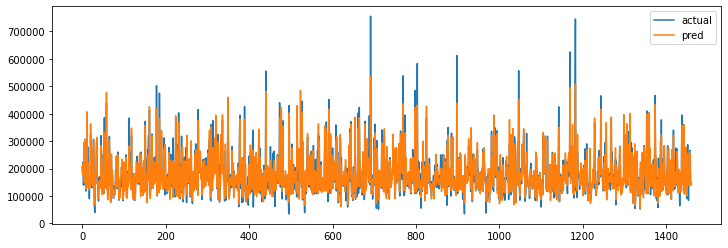

In [175]:
df_diff.plot(figsize=(12, 4))

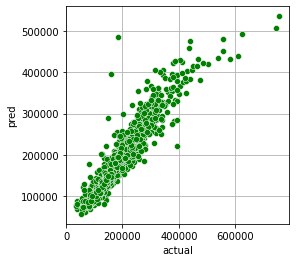

In [176]:
plt.rcParams['figure.figsize'] = [4,4]
fig, ax = plt.subplots()
sns.scatterplot('actual', 'pred',data = df_diff, color = 'g')
ax.set_axisbelow(True)
plt.grid(True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

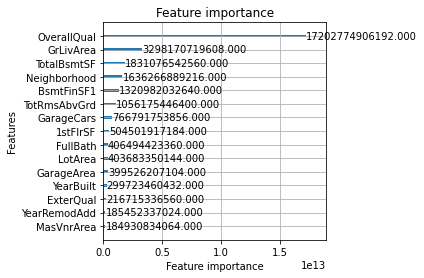

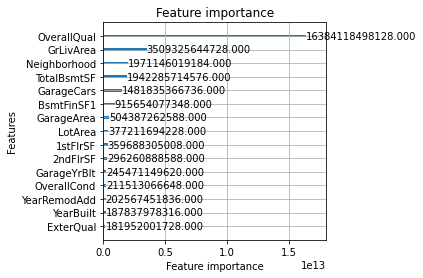

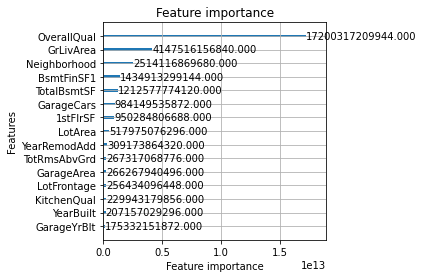

In [177]:
for model in models:
    lgb.plot_importance(model, importance_type='gain', max_num_features = 15)

In [178]:
data_corr = df_all[~df_all.SalePrice.isnull()].drop(['Id'], axis = 1).reset_index(drop=True)
df_impor = pd.DataFrame({'item':data_corr.columns[:-1], 'value':models[0].feature_importance()}).sort_values(by = 'value', ascending = False)
categories = df_impor.item[:10].tolist() + ["SalePrice"]
data_corr1 = data_corr[categories].corr()

<AxesSubplot:>

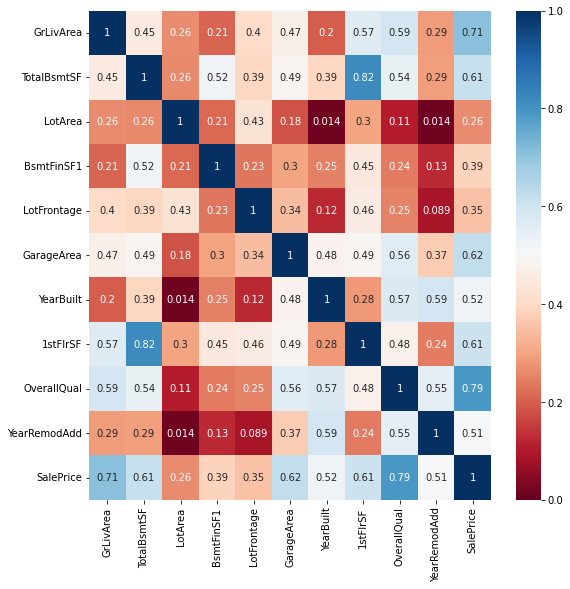

In [179]:
plt.figure(figsize = (9, 9))
sns.heatmap(data_corr1, vmax = 1, vmin = 0, center = 0.5, annot=True, cmap ='RdBu')

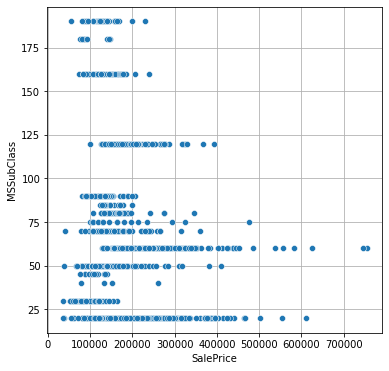

In [180]:
plt.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()
sns.scatterplot('SalePrice', 'GrLivArea', data = data_corr)
ax.set_axisbelow(True)
plt.grid(True)

In [181]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

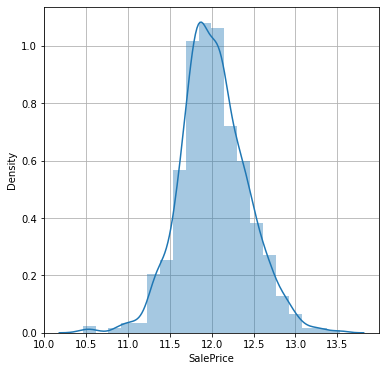

In [182]:
plt.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()
sns.distplot(np.log(data_corr['SalePrice']), bins = 20)
ax.set_axisbelow(True)
plt.grid(True)

In [185]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [186]:
df_train_num = df_train.select_dtypes(include = [np.number])

In [190]:
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

In [193]:
num_features = sorted(list(set(df_train_num) - set(nonratio_features)))

# Linear Regression

In [214]:
df_value = pd.DataFrame(X_train.isnull().sum()).rename(columns = {0:'value'})
df_value[df_value.value > 0].sort_values(by = 'value', ascending = False).index.tolist()

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

In [215]:
cat1 = list(set(X_train.columns.tolist()) - set(df_value[df_value.value > 0].sort_values(by = 'value', ascending = False).index.tolist()))

In [238]:
X_train.fillna(0, inplace = True)

In [239]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train[cat1], Y_train)

LogisticRegression(random_state=0)

In [ ]:
lr.score(X_train[cat1], Y_train)

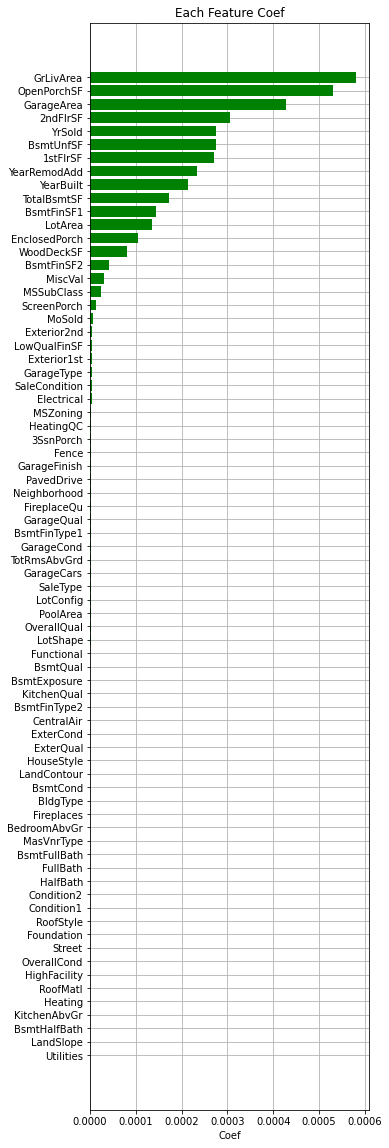

In [252]:
cols = X_train[cat1].columns.tolist()
y_pos = np.arange(len(cols))
df_impor1 = pd.DataFrame(abs(lr.coef_[0]), index=cols, columns=['lr']).sort_values(by='lr', ascending=True)

plt.rcParams['figure.figsize'] = [5,20]
fig, ax = plt.subplots()
ax.barh(df_impor1.index, df_impor1.lr, align = 'center', color = 'g', ecolor = 'k')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_impor1.index)
ax.set_xlabel('Coef')
ax.set_title('Each Feature Coef')
ax.set_axisbelow(True)
plt.grid(True)
plt.show()

In [248]:
len(var_b)

75